# HPC PROJECT PART 1 

Tanner Salvage

This program compares the performance of BiCGstab and GMRES to solve the Poisson Equation.

The PDE is discretised in OpenCL using a centred difference approximation and then converted to a linear operator class to apply the solvers.

Lastly, the solution is validated by comparing to a Fenics implementation. 

In [1]:
# Initialise
from functools import partial
import matplotlib.pyplot as plt
import inspect
import numpy as np
import pyopencl as cl

In [2]:
# Discretise with OpenCL
def solve_poisson_eqn(u, sigma, N):
    """
    """
    kernel = """
    
    __kernel void SolvePoissonEqn(__global double *u,
                                  __global double *result,
                                  __global double *sigma,
                                  int N)
    {
    
    
        int gid = get_global_id(0);
        double h = 1.0/N;
        
        // Only compute on the inner grid
        if(gid < N )
            result[gid] = u[gid];
        else if (gid % N == 0)
            result[gid] = u[gid];
        else if (gid > (N * N - N))
            result[gid] = u[gid];
        else
            // Centred difference approximation
            result[gid] = - 1/(2*h*h) *
                        ((sigma[gid+1] + sigma[gid]) * (u[gid+1] - u[gid]) -
                         (sigma[gid-1] + sigma[gid]) * (u[gid] - u[gid-1]) + 
                         (sigma[gid+N] + sigma[gid]) * (u[gid+N] - u[gid]) -
                         (sigma[gid-N] + sigma[gid]) * (u[gid] - u[gid-N]));
    }
    
    """
    # OpenCL initialisation
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    prg = cl.Program(ctx, kernel).build()
    kernel = prg.SolvePoissonEqn
    
    # Create buffers
    u_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=u)
    sigma_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=sigma)
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR | mf.WRITE_ONLY, size=len(u) * 8)
    
    # Compute result
    kernel(queue, (N*N, ), (1, ), u_buffer, result_buffer, sigma_buffer, np.int32(N)) 
    result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                  0, (N*N, ), np.double)
    
    #result = np.resize(result, (N,N))
    return result

In [3]:
# Solve equation with specified solvers
from scipy.sparse.linalg import LinearOperator, bicgstab,  gmres

# Get residual and number of iterations
class report(object):
    def __init__(self, disp=True):
        # Initialise callback
        self._disp = disp
        self.res = []
        self.niter = 0
        
    def __call__(self, xk, rk = None):
        frame = inspect.currentframe().f_back
        residual = (frame.f_locals['resid'])
        self.res.append(residual)
        self.niter +=1

def use_solver(solver, A, f, N):
    """
    Solve the Poisson equation using a specified FDM solver from the SciPy library.
    A = matrix of coefficients
    f = solution vector
    N = dimensions of system where len(f) = N^2 
    """
    import time
    
    # Include report
    rep = report()
    
    # Solve and time
    start = time.time()
    u_soln, info = solver( A, f, callback=rep, atol= 1e-12)
    end = time.time()

    total_time =  end - start

    # Resize solution into N x N matrix
    u_soln = np.resize(u_soln, (N, N))
    
    return(u_soln, rep.res, rep.niter, total_time)

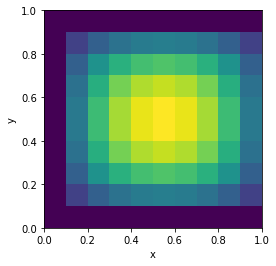

In [4]:
# OpenCL implementation with non linear sigma to compare with FEniCS

# Initialise with N = 10 for demonstration
N = 10
u = np.zeros(N*N)  
f = np.ones(( N * N))
sigma =  1 + u**2

# Convert to linear operator class
A = LinearOperator((N*N,N*N), matvec = partial(solve_poisson_eqn, sigma = sigma, N = N))

# Solve with bicgstab
u_soln, res, niter, time = use_solver(bicgstab, A, f, N)

# plot the graph
plt.imshow(u_soln, extent= [0, 1, 0, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

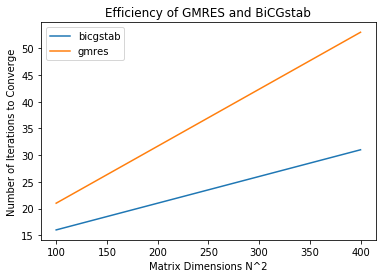

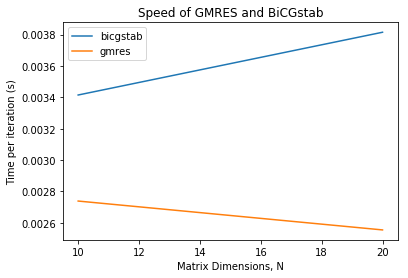

In [5]:
# Experiment 1 - speed and efficiency of BiCGstab and GMRES

# Initialise
solver_array = (bicgstab, gmres)
mean, stdev = 0, 0.1

for solver in solver_array:
    # Initialise
    nIterVec = []
    NsqrVec = []
    costVec = []
    NVec = (10, 20)
    
    for N in NVec:
        # Initialise 
        u = np.zeros(N*N)  
        f = np.ones(( N * N))
        sigma = np.exp(-(np.random.normal(mean, stdev, ((N) * (N)))))

        # Convert to linear operator class
        A = LinearOperator((N*N,N*N), matvec = partial(solve_poisson_eqn, sigma = sigma, N = N))

        # Only store residual of final N
        if (N == 160):
            u_soln, res, niter, total_time = use_solver(solver, A, f, N)
        else:
            u_soln, _, niter, total_time = use_solver(solver, A, f, N)
        
        # Save iteration, N and time info
        nIterVec.append(niter)
        NsqrVec.append(N**2)
        costVec.append(total_time/niter)
    
    # Plot graphs
    plt.figure(1)
    plt.plot(NsqrVec, nIterVec)
    plt.title('Efficiency of GMRES and BiCGstab')
    plt.xlabel('Matrix Dimensions N^2')
    plt.ylabel('Number of Iterations to Converge')
    plt.legend(['bicgstab', 'gmres']) 
    
    plt.figure(2)
    plt.plot(NVec, costVec)
    plt.title('Speed of GMRES and BiCGstab')
    plt.xlabel('Matrix Dimensions, N')
    plt.ylabel('Time per iteration (s)')
    plt.legend(['bicgstab', 'gmres']) 
    
    if (N == 160):
        plt.figure(3)
        plt.plot(np.arange(0, niter, 1), res)
        plt.xlabel('Number of Iterations')
        plt.ylabel('log(residual)')
        plt.yscale('log')
        plt.legend(['bicgstab', 'gmres']) 



Solver: <function bicgstab at 0x112c34ae8>
Number of iteations: 20
total time: 0.08744215965270996


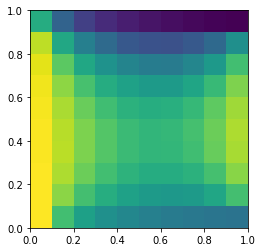

Solver: <function gmres at 0x112c34f28>
Number of iteations: 59
total time: 0.17990899085998535


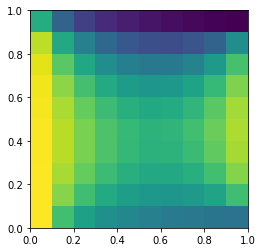

In [6]:
# Experiment 2 - comparison of BiCGstab and GMRES with rhs = cos(x) + sin(y)

# Initialise with N = 10 for demonstration
N = 10

for solver in solver_array:

    f = np.ones(N*N)
    u = np.zeros(N*N)
    sigma = np.exp(-(np.random.normal(mean, stdev, ((N) * (N)))))
    
    for i in range (0,N):
        x = 1./(i+1)
        for j in range (0,N):
            y = 1./(j+1)
            f[i*N + j] = np.cos(x) + np.sin(y)


    # Convert to linear operator class
    A = LinearOperator((N*N,N*N), matvec = partial(solve_poisson_eqn, sigma = sigma, N = N))

    u_soln, _, niter, total_time = use_solver(solver, A, f, N)
    
    print("Solver:", solver)
    print("Number of iteations:", niter)
    print("total time:", total_time)
    
    plt.imshow(u_soln, extent= [0, 1, 0, 1])
    plt.show()

---